<a href="https://colab.research.google.com/github/aveusalex/AulasPDSI/blob/main/Aula2/AbordagemImagetica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

# Carregando dados

https://drive.google.com/drive/folders/1cd3IEnR5gjy5URYjH1JsTK6UBij030NV?usp=share_link

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# primeiramente, devemos obter os nomes de cada arquivo

path_easy = r"/content/drive/MyDrive/EASY" + r"/"  # altere essa string com o diretório da pasta onde os dados estão
path_hard = r"/content/drive/MyDrive/HARD" + r"/"
files_easy = listdir(path_easy)
files_hard = listdir(path_hard)
files_easy

['Apneia2-99_94Hz-28R-88bpm.npz',
 'Apneia1-99_93Hz-38R-85bpm.npz',
 'Apneia4-99_94Hz-50R-69bpm.npz',
 'Apneia3-99_94Hz-13R-67bpm.npz']

> Dica: no nome de cada arquivo está descrito alguns metadados sobre cada captura:
> - a frequência de amostragem do sinal, isto é, quantos pacotes por segundo capturamos;
> - quantas respirações o infivíduo deu durante a coleta (isto é, conjunto de inspiração + expiração);
> - a frequência cardíaca média da pessoa (fora do escopo).

In [ ]:
# agora basta carregar os dados utilizando o numpy
dados_easy = []  # lista que recebe os 4 arrays numpy -> [np.array, np.array...]
dados_hard = []
for easy, hard in zip(files_easy, files_hard):
    dados_easy.append(np.load(path_easy + easy))
    dados_hard.append(np.load(path_hard + hard))

print(f"Quantidade de arquivos carregados: {len(dados_easy)}")

Quantidade de arquivos carregados: 4


In [ ]:
# verificando se os arquivos foram carregados corretamente
error = 0
for arquivo in dados_easy:
    if arquivo.shape != (12000, 171):
        error += 1
for arquivo in dados_hard:
    if arquivo.shape != (12000, 171):
        error += 1

if error != 0:
    print(f"Alguma coisa deu pau! {error} paus!")

else:
    print("Tudo certo!")

Tudo certo!


> Relembrando: é esperado que haja 12000 pacotes e 171 features (subportadoras), sendo 57 subportadoras de cada antena, que consideramos.

In [ ]:
dados_easy[0].shape

(12000, 171)

> Confirmado!

# Segunda abordagem: Visualizando como imagem

In [ ]:
# relembrando o shape
exemplo1 = dados_easy[0]  # obtendo os dados da primeira captura que carregamos
exemplo1.shape

(12000, 171)

> 12 mil pacotes e 57 subportadoras por antenas (3 antenas no total, resultando 171!)

In [ ]:
# Recortando uma janela qualquer de apenas 1000 pacotes para fácil visualização, mas da parte de respiração
janela1 = exemplo1[3500: 4500]

In [ ]:
janela1.shape

(1000, 171)

> No shape que desejamos.

In [ ]:
# Obtendo apenas a parte real do valor complexo -> relativo à amplitude:
janela1_amplitude = abs(janela1)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
# vamos criar uma função para plotar o sinal para nós:
def plota_ai_meu_chegado(sinal, x_label="Pacotes", y_label="Subports/Features/Cores"):
    assert len(sinal.shape) == 2
    fig, ax = plt.subplots(figsize=(16,9))

    # Plot the image on the axis using imshow()
    im = ax.imshow(sinal, cmap='inferno')  # o cmap adequado facilita a visualização, veja o link abaixo para mais
    plt.title("Visualizando as 3 antenas")
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    ### link: https://matplotlib.org/stable/tutorials/colors/colormaps.html

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Add a colorbar to the plot
    cbar = fig.colorbar(im, cax=cax)

    

    # Show the plot
    plt.show()

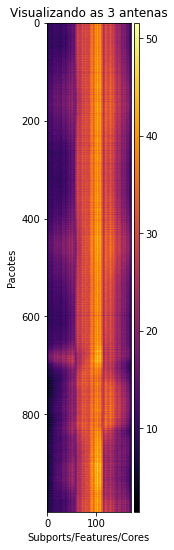

In [ ]:
# Plotando essa janela como uma imagem
plota_ai_meu_chegado(janela1_amplitude, "Subports/Features/Cores", "Pacotes")

> A visualização fica ruim né? Isso acontece porque nosso shape é (1000, 171), o que significa que temos 1000 linhas.

> Para resolver, basta a gente achar a transposta dessa matriz, ou sinal, ou array...

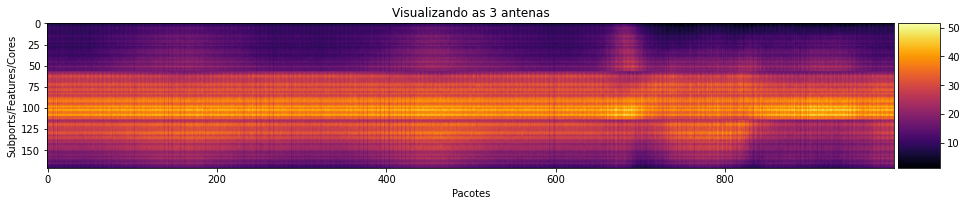

In [ ]:
# Relembrando, todo array numpy tem a propriedade ".T", que já retorna o array transposto para nós!
plota_ai_meu_chegado(janela1_amplitude.T)

> Melhorou! 

Agora, vamos entender o porquê de visualizar uma imagem.

## Entendendo a imagem:

Como já falamos, os nossos dados são capturados de uma placa de Wi-Fi. Essa placa, por sua vez, possui três antenas.

Podemos considerar que a placa de Wi-Fi seja como uma câmera e, como você deve saber, o sensor de uma câmera é feito de pixels -> pequenos pontos sensíveis à luz, que registram a intensidade de cada cor.


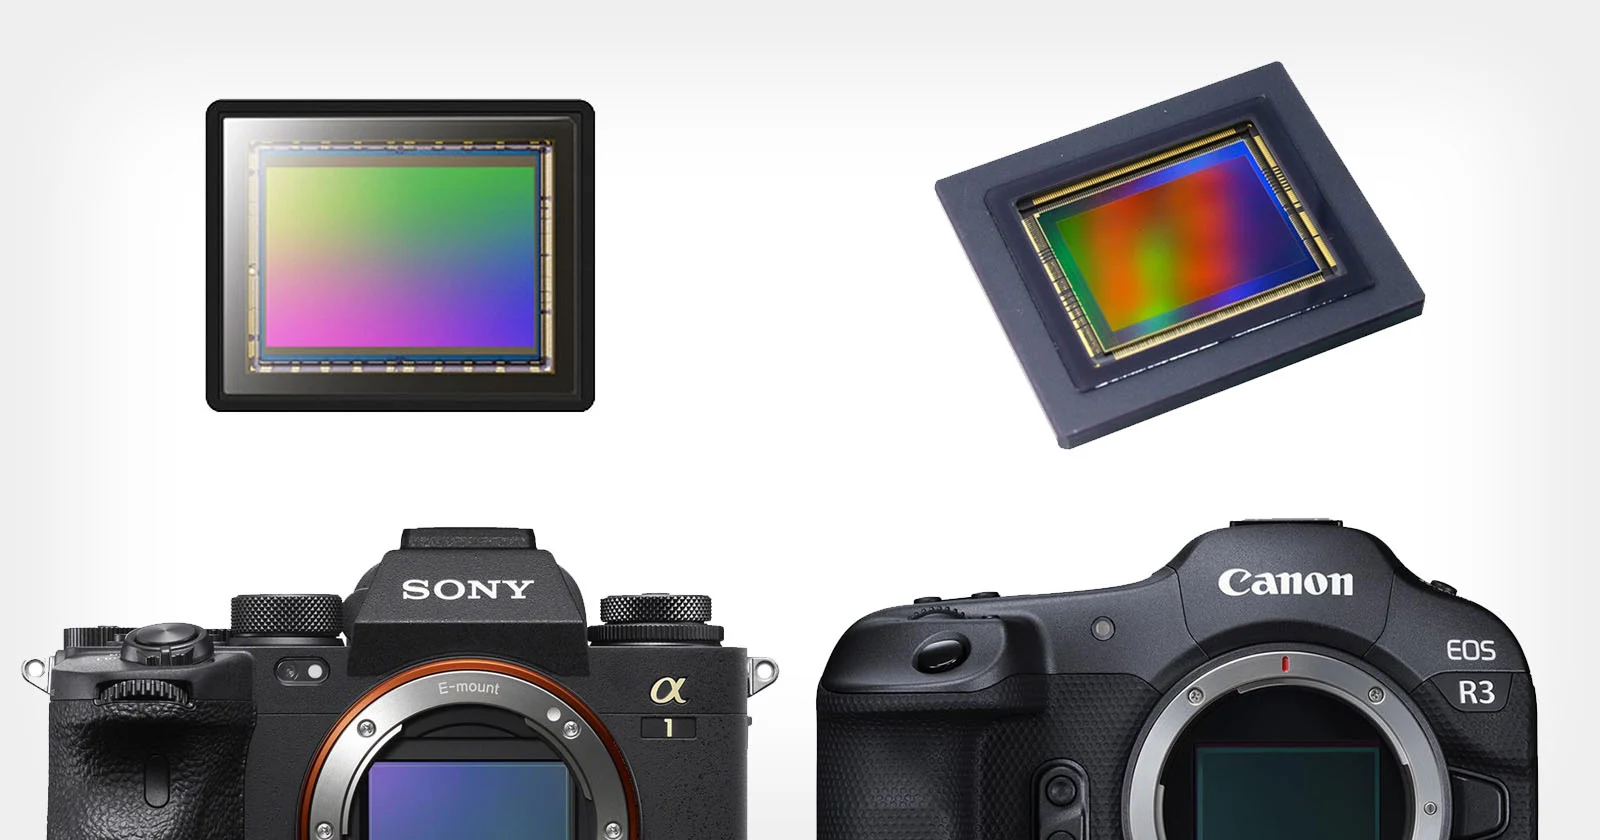

É comum que uma câmera atual tenha 48 megapixels, ou seja, 48 milhões de pixels para capturar a luz e formar uma imagem digital.

Vale ressaltar que cada pixel consegue enxergar 3 cores, ou seja, a profundidade de imagem.

Mas na nossa situação, a placa de wifi (nossa "câmera") tem apenas 3 antenas (os "pixels" dessa câmera) e o segredo está em entender cada subportadora como a profundidade dessa imagem, que no caso é de 57 "cores" (na câmera são apenas 3). 

Nossas capturas possuem 2 dimensões, Quantidade de pacotes e Quantidade de subportadoras. 

Por ser bidimensional, naturalmente surge a vontade de tratar isso como uma imagem. E podemos mesmos! Com algumas adaptações, claro.

In [ ]:
# Temos 3 antenas, mas queremos ver o comportamento de 1 antena por vez, não as três juntas como foi plotado
# Então vamos plotar novamente tomando o cuidado de separar as antenas:

janela1.shape  # relembrando o shape

(1000, 171)

In [ ]:
janela1_ant1 = abs(janela1[:, :57])  # obtendo todos os pacotes de amplitude que são da antena 1
janela1_ant2 = abs(janela1[:, 57: 57*2])
janela1_ant3 = abs(janela1[:, 57*2:57*3])

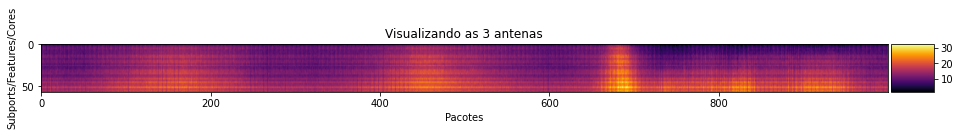

In [ ]:
# plotando essas janelas de cada antena
plota_ai_meu_chegado(janela1_ant1.T)

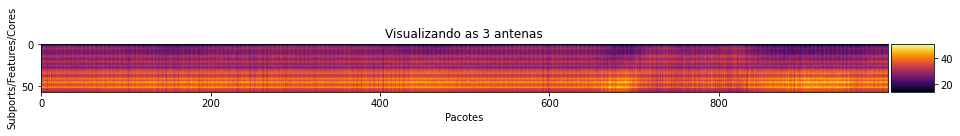

In [ ]:
plota_ai_meu_chegado(janela1_ant2.T)

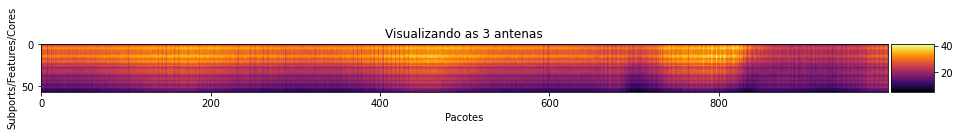

In [ ]:
plota_ai_meu_chegado(janela1_ant3.T)

> Como podemos observar, a imagem é formada naturalmente.

## Plotando as outras capturas

> O Seaborn é melhor!

In [ ]:
import seaborn as sns

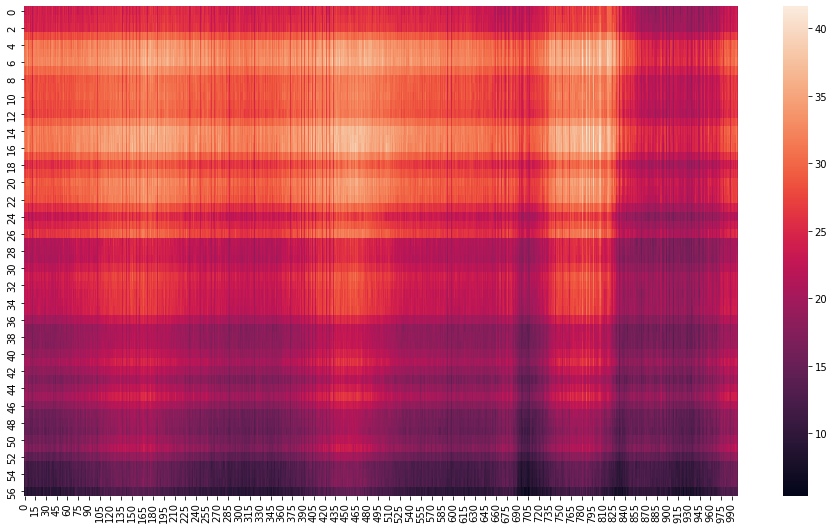

In [ ]:
plt.figure(figsize=(16,9))
sns.heatmap(janela1_ant3.T)  # plotando 1000 pacotes da captura 1 - antena 3 para exemplificar

In [ ]:
# Criando uma função para plotar todas as capturas
def plote_tudo(capturas):
    for capt, filename in zip(capturas, files):
        capt = abs(capt)  # pegando amplitude
        
        plt.figure(figsize=(16,9))
        plt.title(filename)
        sns.heatmap(capt.T)

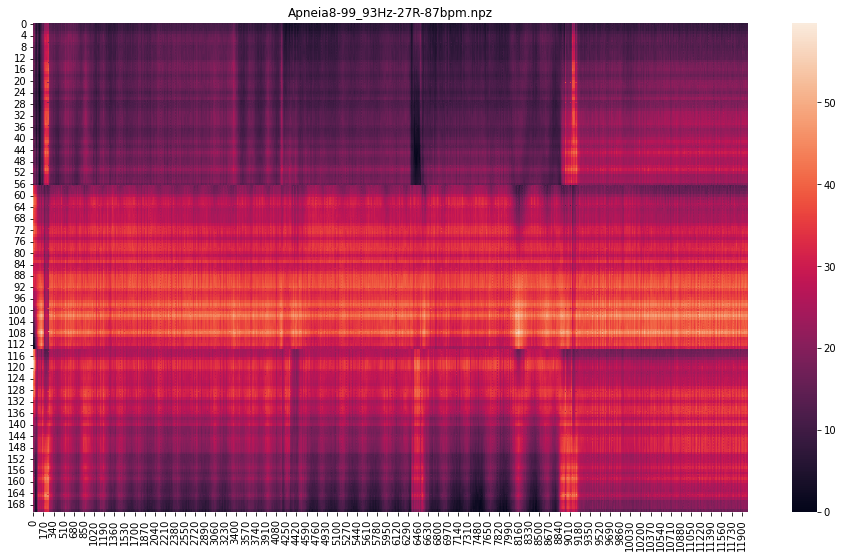

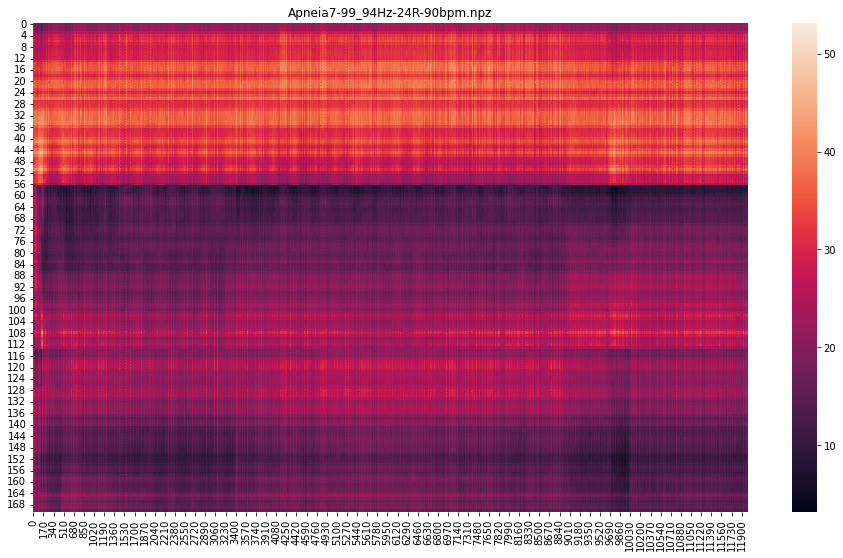

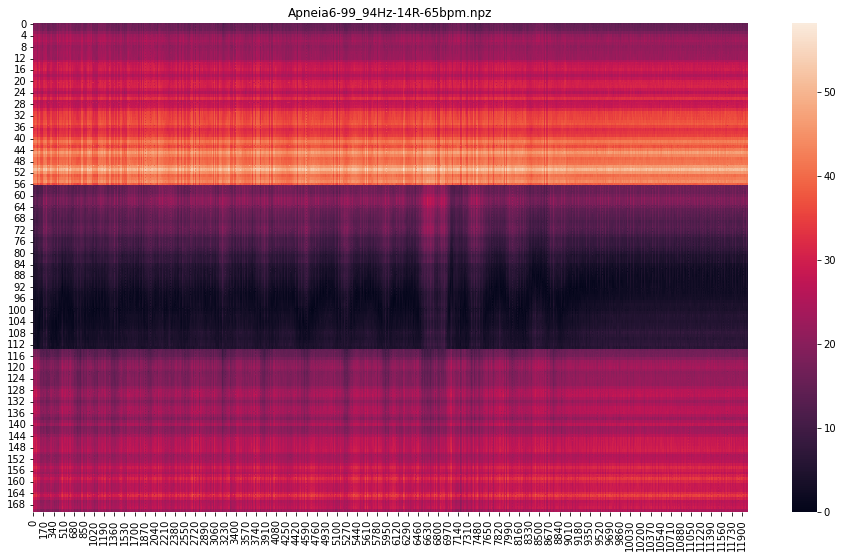

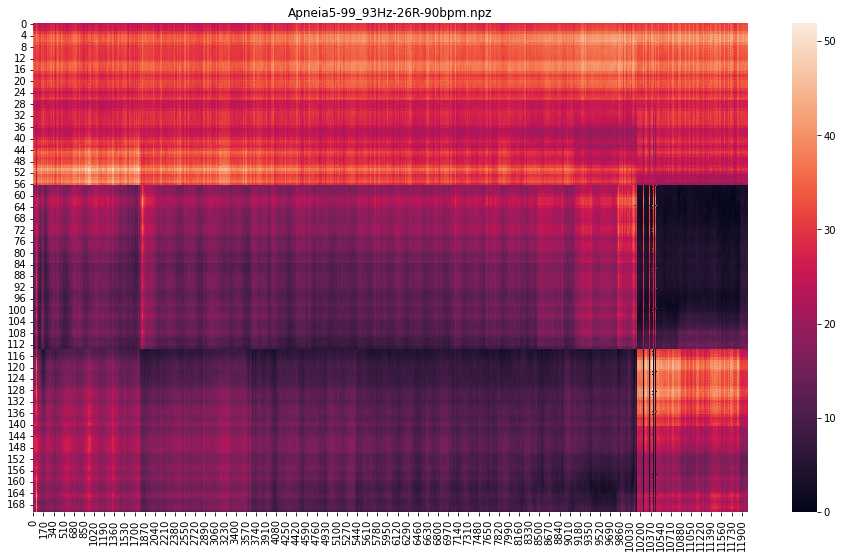

In [ ]:
plote_tudo(dados_easy)

> Perceba que parece difícil de enxergar as nuances... Isso se deve à diferença de escalas entre os dados de cada subportadora. Vamos entender melhor:

### Verificando a diferença de escala entre as subportadoras

In [ ]:
# pegando a captura Apneia2 como exemplo:
files[0]

'Apneia8-99_93Hz-27R-87bpm.npz'

In [ ]:
teste = abs(dados_easy[0])

In [ ]:
max_ant1 = np.max(teste[:,0:57], axis=0)
min_ant1 = np.min(teste[:,0:57], axis=0)
max_ant2 = np.max(teste[:,57:114], axis=0)
min_ant2 = np.min(teste[:,57:114], axis=0)
max_ant3 = np.max(teste[:,114:171], axis=0)
min_ant3 = np.min(teste[:,114:171], axis=0)

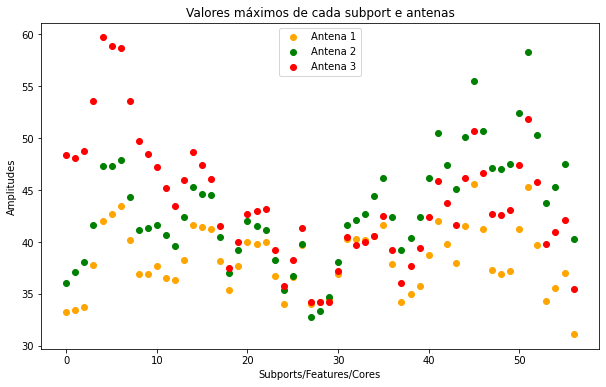

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(range(57), max_ant1, color='orange', label='Antena 1')
plt.scatter(range(57), max_ant2, color='green', label='Antena 2')
plt.scatter(range(57), max_ant3, color='red', label='Antena 3')

plt.title("Valores máximos de cada subport e antenas")
plt.xlabel("Subports/Features/Cores")
plt.ylabel("Amplitudes")
plt.legend()

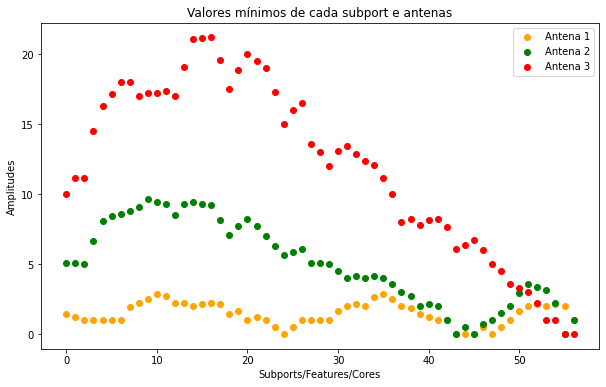

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(range(57), min_ant1, color='orange', label='Antena 1')
plt.scatter(range(57), min_ant2, color='green', label='Antena 2')
plt.scatter(range(57), min_ant3, color='red', label='Antena 3')

plt.title("Valores mínimos de cada subport e antenas")
plt.xlabel("Subports/Features/Cores")
plt.ylabel("Amplitudes")
plt.legend()

## Mãos à obra! Plote, no mesmo jeito que os gráficos acima, os valores médios de cada subportadora para o dado "teste"

In [ ]:
# complete essa célula:

mean_ant1 = 

mean_ant2 = 

mean_ant3 = 


SyntaxError: ignored

In [ ]:
# não precisa mudar nada aqui
plt.figure(figsize=(10,6))
plt.scatter(range(57), mean_ant1, color='orange', label='Antena 1')
plt.scatter(range(57), mean_ant2, color='green', label='Antena 2')
plt.scatter(range(57), mean_ant3, color='red', label='Antena 3')

plt.title("Valores médios de cada subport e antenas")
plt.xlabel("Subports/Features/Cores")
plt.ylabel("Amplitudes")
plt.legend()

## Usando o MinMax scaler para trazer todos à mesma escala:

In [ ]:
from sklearn.preprocessing import MinMaxScaler

> Observação importante: no site do Sklearn, é necessário que o shape dos dados que passemos ao scaler seja de (amostras, features)

In [ ]:
teste.shape

(12000, 171)

> COnfirmado! Nosso shape está correto (amostras, features)

In [ ]:
scaler = MinMaxScaler()  # default do feature range é o intervalo [0, 1]
teste_scaled = scaler.fit_transform(teste)

> Dados transformados! Vamos ver como ficam os gráficos:

In [ ]:
max_ant1 = np.max(teste_scaled[:,0:57], axis=0)
min_ant1 = np.min(teste_scaled[:,0:57], axis=0)
max_ant2 = np.max(teste_scaled[:,57:114], axis=0)
min_ant2 = np.min(teste_scaled[:,57:114], axis=0)
max_ant3 = np.max(teste_scaled[:,114:171], axis=0)
min_ant3 = np.min(teste_scaled[:,114:171], axis=0)

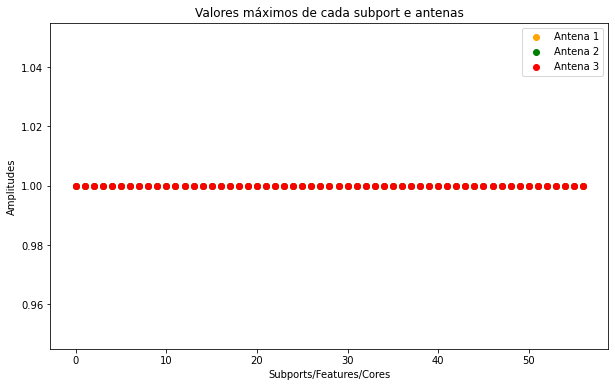

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(range(57), max_ant1, color='orange', label='Antena 1')
plt.scatter(range(57), max_ant2, color='green', label='Antena 2')
plt.scatter(range(57), max_ant3, color='red', label='Antena 3')

plt.title("Valores máximos de cada subport e antenas")
plt.xlabel("Subports/Features/Cores")
plt.ylabel("Amplitudes")
plt.legend()

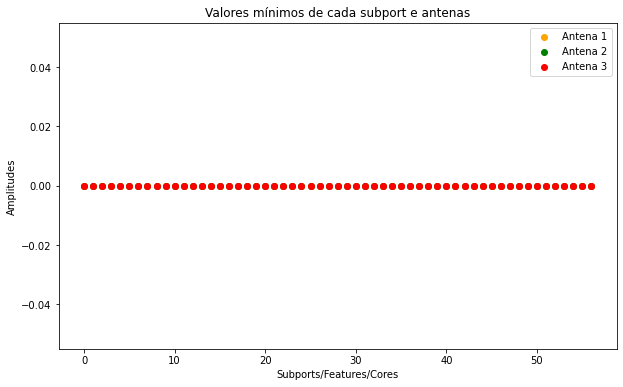

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(range(57), min_ant1, color='orange', label='Antena 1')
plt.scatter(range(57), min_ant2, color='green', label='Antena 2')
plt.scatter(range(57), min_ant3, color='red', label='Antena 3')

plt.title("Valores mínimos de cada subport e antenas")
plt.xlabel("Subports/Features/Cores")
plt.ylabel("Amplitudes")
plt.legend()

> TUdo juntinho!

## Mão à obra: Faça o gráfico de média! (apenas copie e cole o código que vc fez) e discorra sobre o resultado!

In [ ]:
# altere a variável "teste" para "teste_scaled"

## Visualizando as diferenças

In [ ]:
dados_easy_scaled = [scaler.fit_transform(abs(x)) for x in dados_easy]  # reescalando todas as capturas

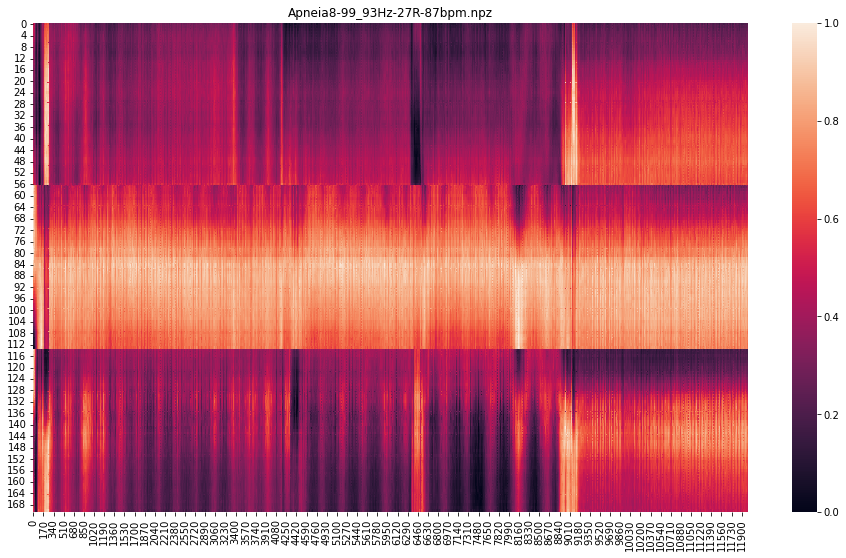

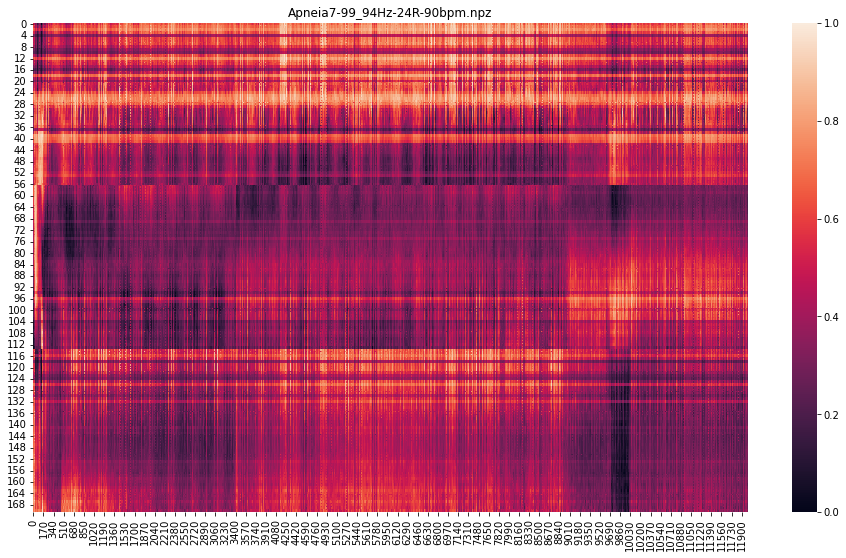

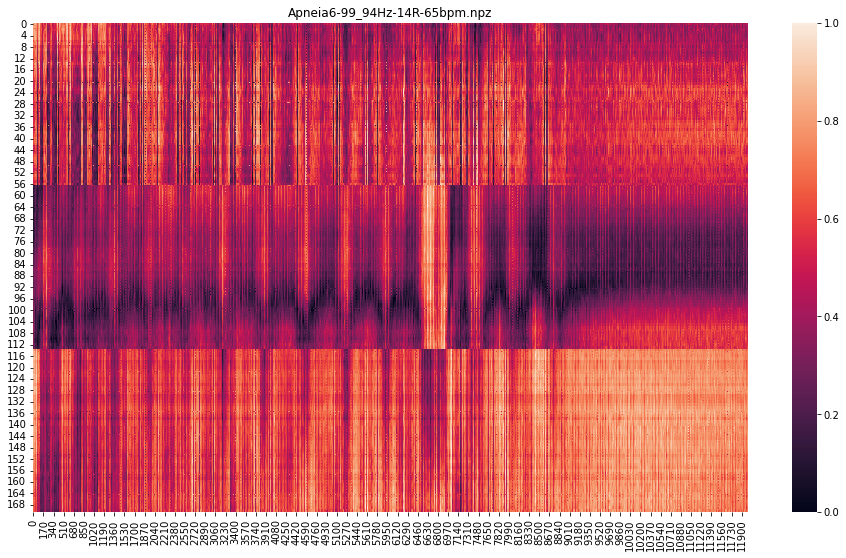

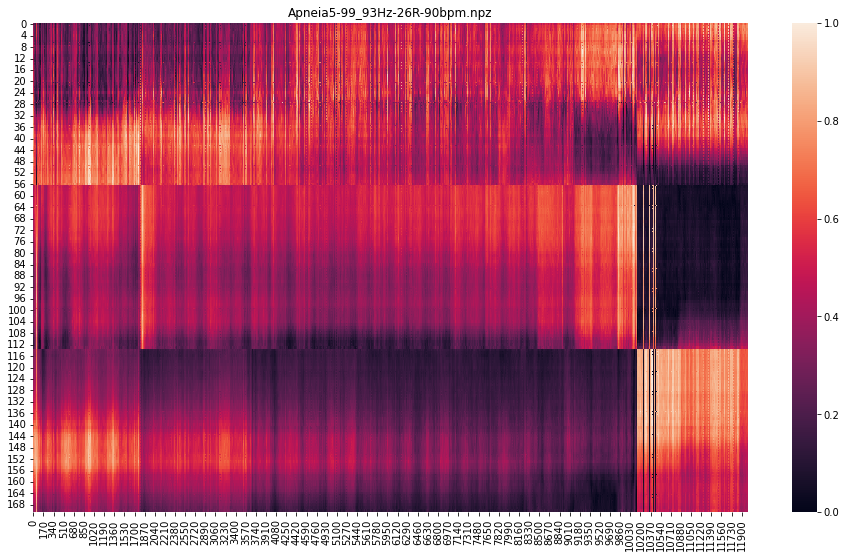

In [ ]:
plote_tudo(dados_easy_scaled)

> Percebam que, explicitamente no último gráfico (referente à apneia 3), parece que se olharmos no mesmo ponto em X, temos ondas em fases diferentes, isto é, onde é vale em uma antena, é crista na outra antena...

# Desafio supremo 💀☠️ - Detecção de respiração e Apneia usando a abordagem de imagem e algoritmos clássicos

> Por se tratar de imagens, a primeira coisa que vem à mente é usar uma rede convolucional. No entanto, podemos abordar isso com classificadores clássicos também.

Agora é contigo! Você, como um bom estudante de sinais e de aprendizado de máquian supervisionado, use seu conhecimento para conseguir detectar quando o sinal representa uma apneia (ausência de respiração) ou se o sinal mostra uma respiração.

Deixei códigos abaixo para auxiliar, então sua tarefa é consumir os dados, separar em treino, teste e validação, treinar um modelo nesses dados e verificar o quanto acertou e o quanto errou!

## Separação dos dados:

In [ ]:
# vamos usar 3 arquivos fáceis e 3 arquivos hard para treinar e deixar o que sobra como teste final intocável durante o treino
teste_final_easy = dados_easy[-1]
teste_final_hard = dados_hard[-1]

In [ ]:
# Criando janelas de tamanho fixo para poder gerar nosso dataset
# Arbitrariamente defini como sendo 500 pacotes a janela (5 segundos)

janelas_respiracao_easy = {}
janelas_apneia_easy = {}

pacotes_a_pular_janelamento = 20

for filename, dado in zip(files_easy[:-1], dados_easy[:-1]):
    janelas_respiracao = []
    janelas_apneia = []
    for idx in range(500, 9000, pacotes_a_pular_janelamento):  # somente respiracao (limite pacote 9000)
        janelas_respiracao.append(dado[idx-500:idx, :])

    for idx in range(9500, 12000, pacotes_a_pular_janelamento):  # somente apneia (do pacote 9500 ao fim)
        janelas_apneia.append(dado[idx-500:idx, :])
    
    janelas_respiracao_easy[filename] = janelas_respiracao
    janelas_apneia_easy[filename] =  janelas_apneia

In [ ]:
janelas_respiracao_hard = {}
janelas_apneia_hard = {}

pacotes_a_pular_janelamento = 20

for filename, dado in zip(files_hard[:-1], dados_hard[:-1]):
    janelas_respiracao = []
    janelas_apneia = []
    for idx in range(500, 9000, pacotes_a_pular_janelamento):  # somente respiracao (limite pacote 9000)
        janelas_respiracao.append(dado[idx-500:idx, :])

    for idx in range(9500, 12000, pacotes_a_pular_janelamento):  # somente apneia (do pacote 9500 ao fim)
        janelas_apneia.append(dado[idx-500:idx, :])
    
    janelas_respiracao_hard[filename] = janelas_respiracao
    janelas_apneia_hard[filename] =  janelas_apneia

> Observação: a estrutura que construímos é um dicionário que as chaves são os filenames, os items são listas que armazenam as janelas que criamos.



>- {"apneia1...": [janela1, janela2, janela3...]}



> O shape de cada janela é de (500, 171)!

In [ ]:
print(f"Quantidade de capturas easy: {len(janelas_respiracao_easy)}")
print(f"Quantidade de capturas hard: {len(janelas_respiracao_hard)}")

Quantidade de capturas easy: 3
Quantidade de capturas hard: 3


In [ ]:
keys_easy = list(janelas_respiracao_easy.keys())
keys_hard = list(janelas_respiracao_hard.keys())

In [ ]:
print(f"Quantidade de janelas easy: {len(janelas_respiracao_easy[keys_easy[0]])}")
print(f"Quantidade de janelas hard: {len(janelas_respiracao_hard[keys_hard[0]])}")

Quantidade de janelas easy: 425
Quantidade de janelas hard: 425
